<a href="../Models/Advanced/Stacking_Classifier_best_model.joblib" target="_self">
  <button style="
    padding:10px 18px;
    font-size:16px;
    background-color:#16a34a;
    color:white;
    border:none;
    border-radius:8px;
    cursor:pointer;">
    🤖 Go to Best Stacking Model
  </button>
</a>


In [1]:
import pandas as pd
import joblib
import os
import logging
import optuna
import warnings
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Ogohlantirishlarni o'chirish
warnings.filterwarnings('ignore')

# =========================
# LOG SETUP
# =========================
log_path = r"C:\Users\Rasulbek907\Desktop\Hotel Booking Cancellation Prediction\Log\data_loader.log"
os.makedirs(os.path.dirname(log_path), exist_ok=True)
logging.basicConfig(filename=log_path, filemode="a",
                    format="%(asctime)s - %(levelname)s - %(message)s",
                    level=logging.INFO)
logging.info("===== FAST STACKING TUNING (15 TRIALS) BOSHLANDI =====")

# =========================
# DATA PATHS & LOADING
# =========================
SMOTE_PATH = r"C:\Users\Rasulbek907\Desktop\Hotel Booking Cancellation Prediction\Data\SMOTE_Data"
FEATURE_PATH = r"C:\Users\Rasulbek907\Desktop\Hotel Booking Cancellation Prediction\Data\Feature_Selection"
PREP_PATH = r"C:\Users\Rasulbek907\Desktop\Hotel Booking Cancellation Prediction\Data\Preprosessed"

X_train = pd.read_csv(os.path.join(SMOTE_PATH, "X_train_selected_smote.csv"))
y_train = pd.read_csv(os.path.join(SMOTE_PATH, "y_train_smote.csv")).values.ravel()
X_test = pd.read_csv(os.path.join(FEATURE_PATH, "X_test_selected.csv"))
y_test = pd.read_csv(os.path.join(PREP_PATH, "y_test.csv")).values.ravel()

# Tuning vaqtini tejash uchun splitni bir marta qilamiz
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=42)

# =========================
# OPTUNA OBJECTIVE (15 TRIALS)
# =========================
def objective(trial):
    # Parametrlarni qidirish diapazoni
    rf_params = {
        "n_estimators": trial.suggest_int("rf_n_estimators", 50, 120),
        "max_depth": trial.suggest_int("rf_max_depth", 5, 12),
        "random_state": 42,
        "n_jobs": 1 # Optuna parallel ishlayotgani uchun ichkarida 1
    }
    
    dt_max_depth = trial.suggest_int("dt_max_depth", 5, 12)
    
    knn_params = {
        "n_neighbors": trial.suggest_int("knn_n_neighbors", 3, 7),
        "weights": trial.suggest_categorical("knn_weights", ["uniform", "distance"]),
        "n_jobs": 1
    }

    # Bazaviy modellar (Tezkor variantlar)
    base_models = [
        ("lr", LogisticRegression(max_iter=500, solver="liblinear", random_state=42)),
        ("rf", RandomForestClassifier(**rf_params)),
        ("dt", DecisionTreeClassifier(max_depth=dt_max_depth, random_state=42)),
        ("knn", KNeighborsClassifier(**knn_params))
    ]

    # Stacking (cv=3 tezlik uchun)
    stacking = StackingClassifier(
        estimators=base_models,
        final_estimator=LogisticRegression(solver="liblinear"),
        cv=3,
        n_jobs=1
    )

    stacking.fit(X_tr, y_tr)
    y_pred = stacking.predict(X_val)
    score = f1_score(y_val, y_pred)
    
    # Pruning (yomon natijalarni kesish)
    trial.report(score, step=0)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return score

# =========================
# RUN OPTUNA (PARALLEL)
# =========================
print("🔍 Optuna eng yaxshi parametrlarni qidirmoqda (15 ta urinish)...")
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=15, n_jobs=-1, show_progress_bar=True)

print(f"✅ Eng yaxshi F1 natija: {study.best_value:.4f}")

# =========================
# FINAL TRAINING (FULL DATA)
# =========================
print("🚀 Final model to'liq ma'lumotda o'qitilmoqda...")
best = study.best_params

final_base_models = [
    ("lr", LogisticRegression(max_iter=1000, solver="liblinear", random_state=42)),
    ("rf", RandomForestClassifier(n_estimators=best["rf_n_estimators"], 
                                  max_depth=best["rf_max_depth"], n_jobs=-1, random_state=42)),
    ("dt", DecisionTreeClassifier(max_depth=best["dt_max_depth"], random_state=42)),
    ("knn", KNeighborsClassifier(n_neighbors=best["knn_n_neighbors"], 
                                  weights=best["knn_weights"], n_jobs=-1))
]

final_model = StackingClassifier(
    estimators=final_base_models,
    final_estimator=LogisticRegression(max_iter=1000, solver="liblinear"),
    cv=5, 
    n_jobs=-1
)

final_model.fit(X_train, y_train)

# =========================
# EVALUATION & SAVING
# =========================
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

f1 = f1_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

logging.info(f"FINAL MODEL - F1: {f1:.4f}, Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, AUC: {roc_auc:.4f}")
logging.info(f"Best Params: {best}")

print("\n📈 Final Metrikalar:")
print(f"F1 Score:  {f1:.4f}")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

# Modelni saqlash
MODEL_PATH = r"C:\Users\Rasulbek907\Desktop\Hotel Booking Cancellation Prediction\Models"
os.makedirs(MODEL_PATH, exist_ok=True)
save_file = os.path.join(MODEL_PATH, "Tuned_Stacking.joblib")
joblib.dump(final_model, save_file)

print(f"\n💾 Model muvaffaqiyatli saqlandi: {save_file}")

c:\Users\Rasulbek907\Desktop\Hotel Booking Cancellation Prediction\mpvenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-12-25 08:03:51,144] A new study created in memory with name: no-name-53c0944c-0722-40cf-9207-c12efc949cb6


🔍 Optuna eng yaxshi parametrlarni qidirmoqda (15 ta urinish)...


Best trial: 1. Best value: 0.865386:   7%|▋         | 1/15 [02:47<38:58, 167.02s/it]

[I 2025-12-25 08:06:38,157] Trial 1 finished with value: 0.8653859071673272 and parameters: {'rf_n_estimators': 53, 'rf_max_depth': 5, 'dt_max_depth': 5, 'knn_n_neighbors': 6, 'knn_weights': 'distance'}. Best is trial 1 with value: 0.8653859071673272.


Best trial: 3. Best value: 0.878523:  13%|█▎        | 2/15 [03:17<18:43, 86.42s/it] 

[I 2025-12-25 08:07:08,154] Trial 3 finished with value: 0.8785234226100913 and parameters: {'rf_n_estimators': 52, 'rf_max_depth': 7, 'dt_max_depth': 5, 'knn_n_neighbors': 3, 'knn_weights': 'distance'}. Best is trial 3 with value: 0.8785234226100913.


Best trial: 3. Best value: 0.878523:  20%|██        | 3/15 [03:33<10:55, 54.59s/it]

[I 2025-12-25 08:07:24,877] Trial 7 finished with value: 0.8579535857852245 and parameters: {'rf_n_estimators': 89, 'rf_max_depth': 5, 'dt_max_depth': 6, 'knn_n_neighbors': 4, 'knn_weights': 'uniform'}. Best is trial 3 with value: 0.8785234226100913.


Best trial: 3. Best value: 0.878523:  27%|██▋       | 4/15 [03:36<06:13, 33.96s/it]

[I 2025-12-25 08:07:27,217] Trial 5 finished with value: 0.8729694827703391 and parameters: {'rf_n_estimators': 75, 'rf_max_depth': 9, 'dt_max_depth': 5, 'knn_n_neighbors': 7, 'knn_weights': 'uniform'}. Best is trial 3 with value: 0.8785234226100913.


Best trial: 3. Best value: 0.878523:  33%|███▎      | 5/15 [03:36<03:39, 21.96s/it]

[I 2025-12-25 08:07:27,899] Trial 4 finished with value: 0.8546950662016186 and parameters: {'rf_n_estimators': 119, 'rf_max_depth': 5, 'dt_max_depth': 6, 'knn_n_neighbors': 6, 'knn_weights': 'uniform'}. Best is trial 3 with value: 0.8785234226100913.


Best trial: 2. Best value: 0.88935:  40%|████      | 6/15 [03:47<02:44, 18.25s/it] 

[I 2025-12-25 08:07:38,935] Trial 2 finished with value: 0.8893504405212556 and parameters: {'rf_n_estimators': 62, 'rf_max_depth': 11, 'dt_max_depth': 7, 'knn_n_neighbors': 4, 'knn_weights': 'distance'}. Best is trial 2 with value: 0.8893504405212556.


Best trial: 2. Best value: 0.88935:  47%|████▋     | 7/15 [03:50<01:45, 13.22s/it]

[I 2025-12-25 08:07:41,787] Trial 0 finished with value: 0.8878980891719745 and parameters: {'rf_n_estimators': 90, 'rf_max_depth': 11, 'dt_max_depth': 9, 'knn_n_neighbors': 6, 'knn_weights': 'distance'}. Best is trial 2 with value: 0.8893504405212556.


Best trial: 6. Best value: 0.889682:  53%|█████▎    | 8/15 [04:02<01:29, 12.77s/it]

[I 2025-12-25 08:07:53,561] Trial 6 finished with value: 0.8896821120689655 and parameters: {'rf_n_estimators': 82, 'rf_max_depth': 12, 'dt_max_depth': 10, 'knn_n_neighbors': 6, 'knn_weights': 'distance'}. Best is trial 6 with value: 0.8896821120689655.


Best trial: 6. Best value: 0.889682:  60%|██████    | 9/15 [05:19<03:16, 32.76s/it]

[I 2025-12-25 08:09:10,318] Trial 8 finished with value: 0.8856818333667401 and parameters: {'rf_n_estimators': 109, 'rf_max_depth': 6, 'dt_max_depth': 12, 'knn_n_neighbors': 6, 'knn_weights': 'distance'}. Best is trial 6 with value: 0.8896821120689655.


Best trial: 6. Best value: 0.889682:  67%|██████▋   | 10/15 [06:38<03:55, 47.18s/it]

[I 2025-12-25 08:10:29,789] Trial 10 pruned. 


Best trial: 6. Best value: 0.889682:  73%|███████▎  | 11/15 [06:43<02:17, 34.30s/it]

[I 2025-12-25 08:10:34,890] Trial 12 finished with value: 0.8860164512338425 and parameters: {'rf_n_estimators': 87, 'rf_max_depth': 9, 'dt_max_depth': 11, 'knn_n_neighbors': 7, 'knn_weights': 'distance'}. Best is trial 6 with value: 0.8896821120689655.


Best trial: 6. Best value: 0.889682:  80%|████████  | 12/15 [06:44<01:12, 24.19s/it]

[I 2025-12-25 08:10:35,951] Trial 9 pruned. 
[I 2025-12-25 08:10:35,993] Trial 14 finished with value: 0.8825818572195384 and parameters: {'rf_n_estimators': 75, 'rf_max_depth': 9, 'dt_max_depth': 8, 'knn_n_neighbors': 5, 'knn_weights': 'distance'}. Best is trial 6 with value: 0.8896821120689655.


Best trial: 6. Best value: 0.889682:  93%|█████████▎| 14/15 [07:00<00:16, 16.58s/it]

[I 2025-12-25 08:10:51,609] Trial 13 pruned. 


Best trial: 6. Best value: 0.889682: 100%|██████████| 15/15 [07:01<00:00, 28.12s/it]


[I 2025-12-25 08:10:52,898] Trial 11 pruned. 
✅ Eng yaxshi F1 natija: 0.8897
🚀 Final model to'liq ma'lumotda o'qitilmoqda...

📈 Final Metrikalar:
F1 Score:  0.8007
Accuracy:  0.8540
Precision: 0.8220
Recall:    0.7804
ROC-AUC:   0.9262

💾 Model muvaffaqiyatli saqlandi: C:\Users\Rasulbek907\Desktop\Hotel Booking Cancellation Prediction\Models\Tuned_Stacking.joblib


In [4]:
import pandas as pd
import joblib
import os
import logging
import optuna
import warnings
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Ogohlantirishlarni o'chirish
warnings.filterwarnings('ignore')

# =========================
# LOG SETUP
# =========================
log_path = r"C:\Users\Rasulbek907\Desktop\Hotel Booking Cancellation Prediction\Log\random_forest_tuning.log"
os.makedirs(os.path.dirname(log_path), exist_ok=True)
logging.basicConfig(filename=log_path, filemode="a",
                    format="%(asctime)s - %(levelname)s - %(message)s",
                    level=logging.INFO)
logging.info("===== RANDOM FOREST OPTUNA TUNING BOSHLANDI =====")

# =========================
# DATA PATHS & LOADING
# =========================
SMOTE_PATH = r"C:\Users\Rasulbek907\Desktop\Hotel Booking Cancellation Prediction\Data\SMOTE_Data"
FEATURE_PATH = r"C:\Users\Rasulbek907\Desktop\Hotel Booking Cancellation Prediction\Data\Feature_Selection"
PREP_PATH = r"C:\Users\Rasulbek907\Desktop\Hotel Booking Cancellation Prediction\Data\Preprosessed"

X_train = pd.read_csv(os.path.join(SMOTE_PATH, "X_train_selected_smote.csv"))
y_train = pd.read_csv(os.path.join(SMOTE_PATH, "y_train_smote.csv")).values.ravel()
X_test = pd.read_csv(os.path.join(FEATURE_PATH, "X_test_selected.csv"))
y_test = pd.read_csv(os.path.join(PREP_PATH, "y_test.csv")).values.ravel()

# Tuning vaqtini tejash uchun kichik split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=42)

# =========================
# OPTUNA OBJECTIVE (RANDOM FOREST)
# =========================
def objective(trial):
    # Random Forest uchun qidiruv parametrlari
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "max_depth": trial.suggest_int("max_depth", 10, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "n_jobs": -1,
        "random_state": 42
    }

    model = RandomForestClassifier(**params)
    model.fit(X_tr, y_tr)
    
    y_pred = model.predict(X_val)
    score = f1_score(y_val, y_pred)
    
    # Pruning (yomon urinishlarni to'xtatish)
    trial.report(score, step=0)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return score

# =========================
# RUN OPTUNA
# =========================
print("🔍 Random Forest uchun eng yaxshi parametrlarni qidirmoqda (15 ta urinish)...")
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=15, n_jobs=1, show_progress_bar=True)

print(f"✅ Eng yaxshi F1 natija: {study.best_value:.4f}")

# =========================
# FINAL TRAINING (FULL DATA)
# =========================
print("🚀 Final Random Forest modeli o'qitilmoqda...")
best_params = study.best_params

final_model = RandomForestClassifier(**best_params, n_jobs=-1, random_state=42)
final_model.fit(X_train, y_train)

# =========================
# EVALUATION & SAVING
# =========================
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

f1 = f1_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

logging.info(f"FINAL RF - F1: {f1:.4f}, Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, AUC: {roc_auc:.4f}")
logging.info(f"Best Params: {best_params}")

print("\n📈 Final Metrikalar (Random Forest):")
print(f"F1 Score:  {f1:.4f}")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

# Modelni saqlash
MODEL_PATH = r"C:\Users\Rasulbek907\Desktop\Hotel Booking Cancellation Prediction\Models"
os.makedirs(MODEL_PATH, exist_ok=True)
save_file = os.path.join(MODEL_PATH, "Tuned_RandomForest.joblib")
joblib.dump(final_model, save_file)

print(f"\n💾 Model muvaffaqiyatli saqlandi: {save_file}")

[I 2025-12-25 08:20:50,899] A new study created in memory with name: no-name-527d1fac-035d-40b2-94b3-107a1e695a05


🔍 Random Forest uchun eng yaxshi parametrlarni qidirmoqda (15 ta urinish)...


Best trial: 0. Best value: 0.878704:   7%|▋         | 1/15 [00:03<00:54,  3.89s/it]

[I 2025-12-25 08:20:54,788] Trial 0 finished with value: 0.8787036083359082 and parameters: {'n_estimators': 123, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8787036083359082.


Best trial: 1. Best value: 0.895397:  13%|█▎        | 2/15 [00:12<01:25,  6.59s/it]

[I 2025-12-25 08:21:03,272] Trial 1 finished with value: 0.8953972042277532 and parameters: {'n_estimators': 252, 'max_depth': 26, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 0.8953972042277532.


Best trial: 1. Best value: 0.895397:  20%|██        | 3/15 [00:21<01:32,  7.73s/it]

[I 2025-12-25 08:21:12,347] Trial 2 finished with value: 0.890490504167236 and parameters: {'n_estimators': 276, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 0.8953972042277532.


Best trial: 1. Best value: 0.895397:  27%|██▋       | 4/15 [00:26<01:13,  6.65s/it]

[I 2025-12-25 08:21:17,351] Trial 3 finished with value: 0.8795077176939736 and parameters: {'n_estimators': 183, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 0.8953972042277532.


Best trial: 1. Best value: 0.895397:  33%|███▎      | 5/15 [00:33<01:08,  6.87s/it]

[I 2025-12-25 08:21:24,615] Trial 4 finished with value: 0.875068870523416 and parameters: {'n_estimators': 254, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 1 with value: 0.8953972042277532.


Best trial: 1. Best value: 0.895397:  40%|████      | 6/15 [00:41<01:05,  7.24s/it]

[I 2025-12-25 08:21:32,581] Trial 5 finished with value: 0.8795081404135467 and parameters: {'n_estimators': 280, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8953972042277532.


Best trial: 6. Best value: 0.900296:  47%|████▋     | 7/15 [00:51<01:04,  8.12s/it]

[I 2025-12-25 08:21:42,506] Trial 6 finished with value: 0.9002957473569705 and parameters: {'n_estimators': 288, 'max_depth': 24, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.9002957473569705.


Best trial: 6. Best value: 0.900296:  53%|█████▎    | 8/15 [00:57<00:51,  7.40s/it]

[I 2025-12-25 08:21:48,358] Trial 7 finished with value: 0.8822156633948796 and parameters: {'n_estimators': 199, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.9002957473569705.


Best trial: 6. Best value: 0.900296:  60%|██████    | 9/15 [01:02<00:40,  6.74s/it]

[I 2025-12-25 08:21:53,639] Trial 8 finished with value: 0.8926337378225945 and parameters: {'n_estimators': 165, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.9002957473569705.


Best trial: 6. Best value: 0.900296:  67%|██████▋   | 10/15 [01:08<00:31,  6.33s/it]

[I 2025-12-25 08:21:59,060] Trial 9 finished with value: 0.8971199019541091 and parameters: {'n_estimators': 149, 'max_depth': 26, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 6 with value: 0.9002957473569705.


Best trial: 6. Best value: 0.900296:  73%|███████▎  | 11/15 [01:16<00:27,  6.83s/it]

[I 2025-12-25 08:22:07,023] Trial 10 finished with value: 0.8946453526023382 and parameters: {'n_estimators': 227, 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.9002957473569705.


Best trial: 6. Best value: 0.900296:  80%|████████  | 12/15 [01:20<00:18,  6.16s/it]

[I 2025-12-25 08:22:11,638] Trial 11 finished with value: 0.8945647731916633 and parameters: {'n_estimators': 136, 'max_depth': 24, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 6 with value: 0.9002957473569705.


Best trial: 6. Best value: 0.900296:  87%|████████▋ | 13/15 [01:24<00:10,  5.45s/it]

[I 2025-12-25 08:22:15,464] Trial 12 finished with value: 0.8984313858926809 and parameters: {'n_estimators': 104, 'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 6 with value: 0.9002957473569705.


Best trial: 6. Best value: 0.900296:  93%|█████████▎| 14/15 [01:28<00:04,  4.95s/it]

[I 2025-12-25 08:22:19,240] Trial 13 finished with value: 0.897538052916539 and parameters: {'n_estimators': 103, 'max_depth': 24, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.9002957473569705.


Best trial: 6. Best value: 0.900296: 100%|██████████| 15/15 [01:38<00:00,  6.55s/it]


[I 2025-12-25 08:22:29,212] Trial 14 finished with value: 0.895205596314622 and parameters: {'n_estimators': 298, 'max_depth': 21, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 6 with value: 0.9002957473569705.
✅ Eng yaxshi F1 natija: 0.9003
🚀 Final Random Forest modeli o'qitilmoqda...

📈 Final Metrikalar (Random Forest):
F1 Score:  0.8334
Accuracy:  0.8795
Precision: 0.8672
Recall:    0.8021
ROC-AUC:   0.9513

💾 Model muvaffaqiyatli saqlandi: C:\Users\Rasulbek907\Desktop\Hotel Booking Cancellation Prediction\Models\Tuned_RandomForest.joblib


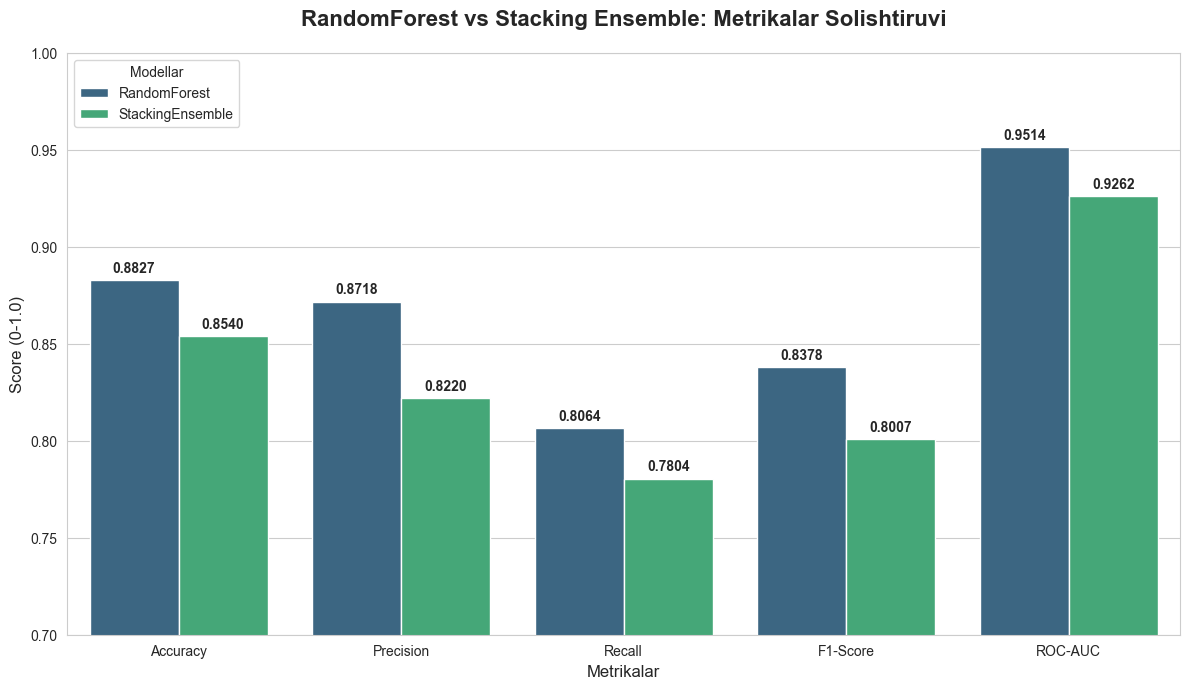

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 1. Ma'lumotlarni tayyorlash
data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'RandomForest': [0.8827, 0.8718, 0.8064, 0.8378, 0.9514],
    'StackingEnsemble': [0.8540, 0.8220, 0.7804, 0.8007, 0.9262]
}

df = pd.DataFrame(data)

# Ma'lumotlarni "long-format"ga o'tkazamiz (vizuallashtirishga qulay bo'lishi uchun)
df_melted = df.melt(id_vars='Metric', var_name='Model', value_name='Score')

# 2. Grafik chizish
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# Ranglar va ustunlar
plot = sns.barplot(data=df_melted, x='Metric', y='Score', hue='Model', palette='viridis')

# Qiymatlarni ustunlar ustiga yozish
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.4f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',
                   fontsize=10, fontweight='bold')

# 3. Grafik bezaklari
plt.title('RandomForest vs Stacking Ensemble: Metrikalar Solishtiruvi', fontsize=16, fontweight='bold', pad=20)
plt.ylim(0.7, 1.0)  # Farqlarni aniqroq ko'rish uchun pastki chegarani 0.7 qildik
plt.ylabel('Score (0-1.0)', fontsize=12)
plt.xlabel('Metrikalar', fontsize=12)
plt.legend(title='Modellar', loc='upper left')

plt.tight_layout()
plt.show()

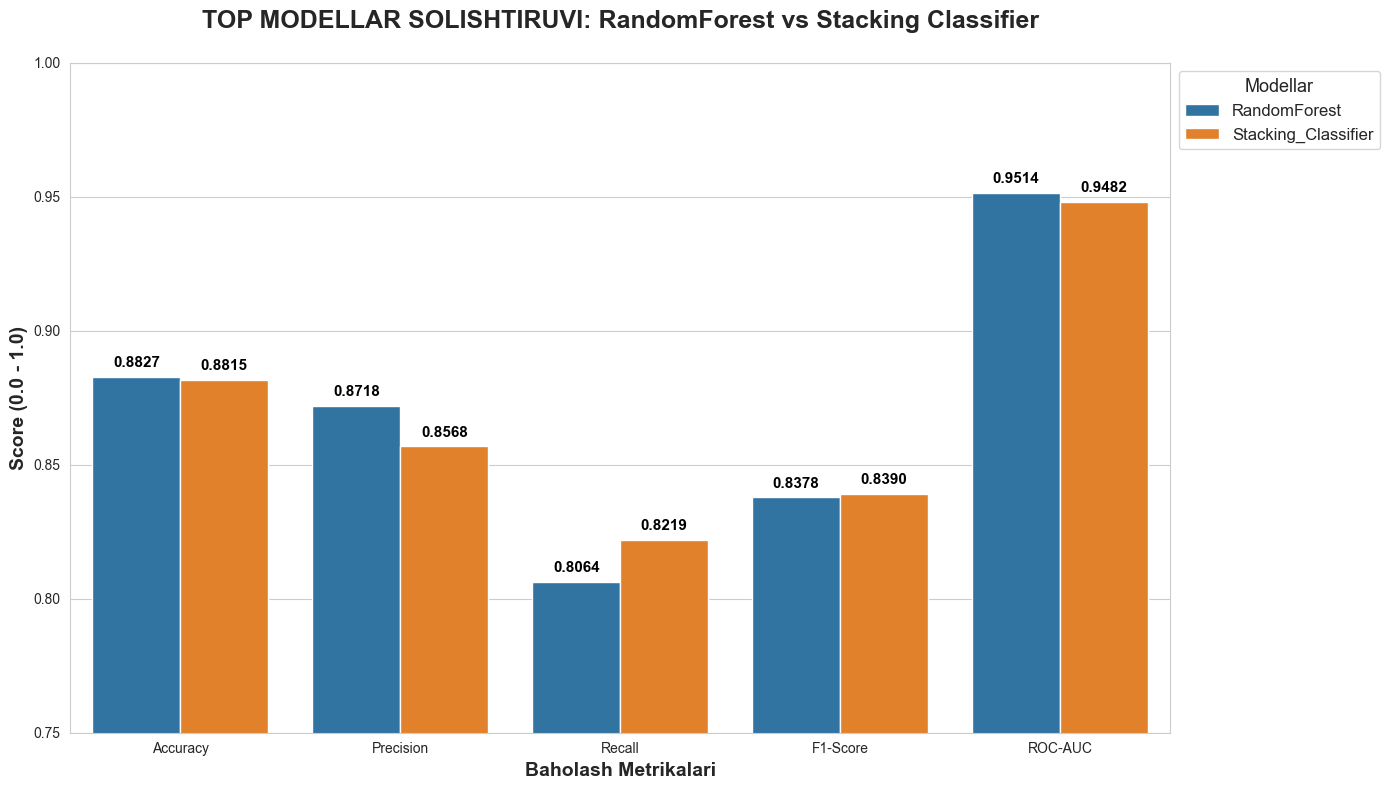

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 1. Ma'lumotlarni kiritish
# Siz bergan eng yuqori ko'rsatkichlarni jamlaymiz
data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'RandomForest': [0.8827, 0.8718, 0.8064, 0.8378, 0.9514],
    'Stacking_Classifier': [0.8815, 0.8568, 0.8219, 0.8390, 0.9482]
}

df = pd.DataFrame(data)

# Grafik uchun ma'lumotni formatlash (Melt)
df_melted = df.melt(id_vars='Metric', var_name='Model', value_name='Score')

# 2. Grafikni yaratish
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# Ranglar palitrasini tanlash (Sifatli va farqlanuvchi)
colors = ["#1f77b4", "#ff7f0e"] # Ko'k va To'q sariq
plot = sns.barplot(data=df_melted, x='Metric', y='Score', hue='Model', palette=colors)

# 3. Ustunlar ustiga qiymatlarni yozib chiqish
for p in plot.patches:
    if p.get_height() > 0: # 0 bo'lmagan qiymatlar uchun
        plot.annotate(format(p.get_height(), '.4f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 10), 
                       textcoords = 'offset points',
                       fontsize=11, fontweight='bold', color='black')

# 4. Grafik bezaklari
plt.title('TOP MODELLAR SOLISHTIRUVI: RandomForest vs Stacking Classifier', fontsize=18, fontweight='bold', pad=25)
plt.ylim(0.75, 1.0)  # Farqlar yaqqol ko'rinishi uchun (0.75 dan boshladik)
plt.ylabel('Score (0.0 - 1.0)', fontsize=14, fontweight='bold')
plt.xlabel('Baholash Metrikalari', fontsize=14, fontweight='bold')
plt.legend(title='Modellar', title_fontsize='13', fontsize='12', loc='upper left', bbox_to_anchor=(1, 1))

# Grafikni ekranga moslashtirish
plt.tight_layout()

# Grafikni rasm sifatida saqlash (ixtiyoriy)
# plt.savefig("top_models_comparison.png", dpi=300)

plt.show()